## Problem Statement
An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses.

The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%.

Now, although X Education gets a lot of leads, its lead conversion rate is very poor. For example, if, say, they acquire 100 leads in a day, only about 30 of them are converted. To make this process more efficient, the company wishes to identify the most potential leads, also known as ‘Hot Leads’. If they successfully identify this set of leads, the lead conversion rate should go up as the sales team will now be focusing more on communicating with the potential leads rather than making calls to everyone. A typical lead conversion process can be represented using the following funnel:

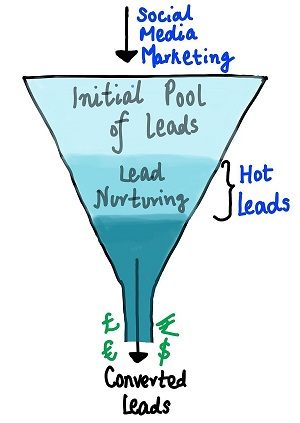




**"The company requires a model that will assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance."**

In [153]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('ggplot')

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, accuracy_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 50)



In [154]:
!pip install jovian -q --upgrade
import jovian

In [155]:
# Importing data
df = pd.read_csv("Leads.csv")
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [156]:
#Checking info
df.shape
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [157]:
round(df.isnull().sum()/len(df)*100,1)

Prospect ID                                       0.0
Lead Number                                       0.0
Lead Origin                                       0.0
Lead Source                                       0.4
Do Not Email                                      0.0
Do Not Call                                       0.0
Converted                                         0.0
TotalVisits                                       1.5
Total Time Spent on Website                       0.0
Page Views Per Visit                              1.5
Last Activity                                     1.1
Country                                          26.6
Specialization                                   15.6
How did you hear about X Education               23.9
What is your current occupation                  29.1
What matters most to you in choosing a course    29.3
Search                                            0.0
Magazine                                          0.0
Newspaper Article           

In [158]:
df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


### Data Checking

In [159]:
#check for duplicates
sum(df.duplicated(subset = 'Prospect ID')) == 0

True

***No duplicate values in Prospect ID***

In [160]:
#check for duplicates
sum(df.duplicated(subset = 'Lead Number')) == 0

True

***No duplicate values in Lead Number***

Clearly Prospect ID & Lead Number are two variables that are just indicative of the ID number of the Contacted People & can be dropped.

## Exploratory Data Analysis

### Treatment of data and its cleaning

In [161]:
#dropping Lead Number and Prospect ID since they have all unique values

df.drop(['Prospect ID', 'Lead Number'], 1, inplace = True)

In [162]:
df.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [163]:
#Converting 'Select' values to NaN. This is to be done because 'select' has to be replaced to compute actual null values

df = df.replace('Select', np.nan)

In [164]:
# Again checking the percentage of null values
round(df.isnull().sum()/len(df)*100,2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

In [165]:
df.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,NaN,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,NaN,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,NaN,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,NaN,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [166]:
#dropping cols with more than 45% missing values

cols=df.columns

for i in cols:
    if((100*(df[i].isnull().sum()/len(df.index))) >= 45):
        df.drop(i, 1, inplace = True)

In [167]:
round(df.isnull().sum()/len(df)*100,1)

Lead Origin                                       0.0
Lead Source                                       0.4
Do Not Email                                      0.0
Do Not Call                                       0.0
Converted                                         0.0
TotalVisits                                       1.5
Total Time Spent on Website                       0.0
Page Views Per Visit                              1.5
Last Activity                                     1.1
Country                                          26.6
Specialization                                   36.6
What is your current occupation                  29.1
What matters most to you in choosing a course    29.3
Search                                            0.0
Magazine                                          0.0
Newspaper Article                                 0.0
X Education Forums                                0.0
Newspaper                                         0.0
Digital Advertisement       

In [168]:
df.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,No,No,NaN,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,NaN,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Mumbai,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,Mumbai,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Mumbai,No,No,Modified


## Analysis for Categorical values

In [169]:
#checking value counts of Country column

df['Country'].value_counts(dropna=False)

India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Philippines                2
Uganda                     2
Italy                      2
Bangladesh                 2
Netherlands                2
Asia/Pacific Region        2
China                      2
Belgium                    2
Ghana                      2
Kenya                      1
Sri Lanka                  1
Tanzania                   1
Malaysia                   1
Liberia                    1
Switzerland   

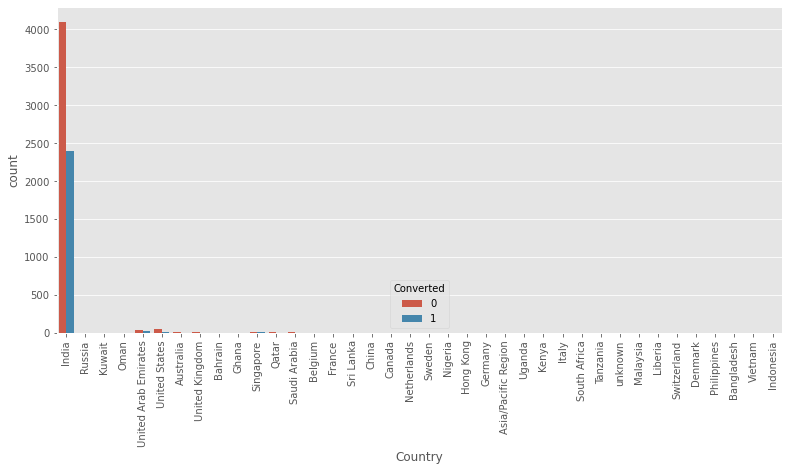

In [170]:
#plotting spread of Country columnn 
plt.figure(figsize=(13,6))
s1=sns.countplot(df.Country,hue=df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [171]:
# Since India is the most common occurence among the non-missing values we can impute all missing values with India

df['Country'] = df.Country.replace(np.nan,'India')

In [172]:
#checking again value counts of Country column

df['City'].value_counts(dropna=False)

NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

In [173]:
df['City'] = df['City'].replace(np.nan,'Mumbai')

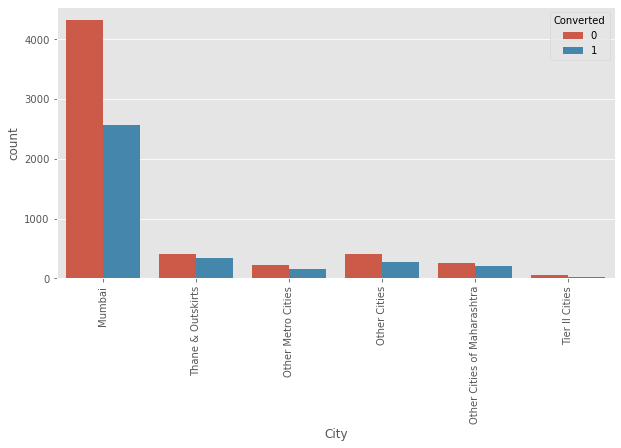

In [174]:
#plotting spread of City columnn after replacing NaN values

plt.figure(figsize=(10,5))
s1=sns.countplot(df.City, hue=df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

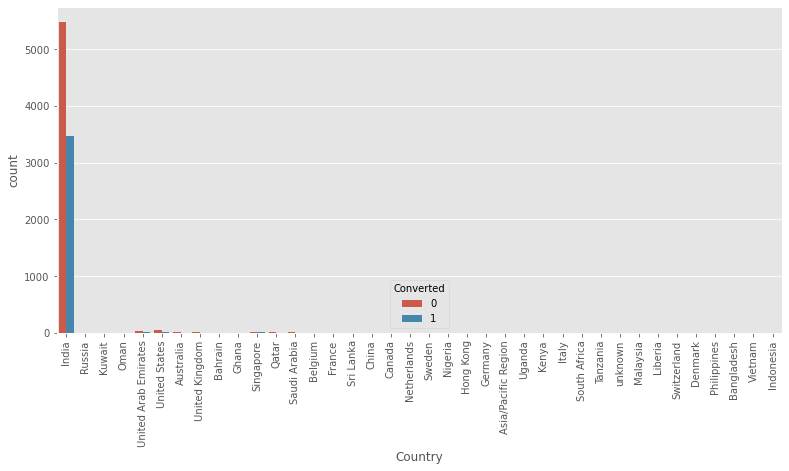

In [175]:
#plotting spread of Country columnn after replacing NaN values

plt.figure(figsize=(13,6))
s1=sns.countplot(df.Country, hue=df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [176]:
round(100*df['Country'].value_counts(normalize=True),2)

India                   96.89
United States            0.75
United Arab Emirates     0.57
Singapore                0.26
Saudi Arabia             0.23
United Kingdom           0.16
Australia                0.14
Qatar                    0.11
Hong Kong                0.08
Bahrain                  0.08
Oman                     0.06
France                   0.06
unknown                  0.05
South Africa             0.04
Nigeria                  0.04
Germany                  0.04
Kuwait                   0.04
Canada                   0.04
Sweden                   0.03
China                    0.02
Asia/Pacific Region      0.02
Uganda                   0.02
Bangladesh               0.02
Italy                    0.02
Belgium                  0.02
Netherlands              0.02
Ghana                    0.02
Philippines              0.02
Russia                   0.01
Switzerland              0.01
Vietnam                  0.01
Denmark                  0.01
Tanzania                 0.01
Liberia   

***As we can see the Number of Values for India are quite high (nearly 97% of the Data), this column can be dropped***


-Creating a list of columns which has to be dropped over the EDA phase

In [177]:
#creating a list of columns to be droppped

cols_to_drop=['Country']

In [178]:
#checking value counts of Specialization column

df['Specialization'].value_counts(dropna=False)

NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

In [179]:
# Lead may not have mentioned specialization because it was not in the list or maybe they are a students 
# and don't have a specialization yet. So we will replace NaN values here with 'Not Specified'

df['Specialization'] = df['Specialization'].replace(np.nan, 'Not Specified')

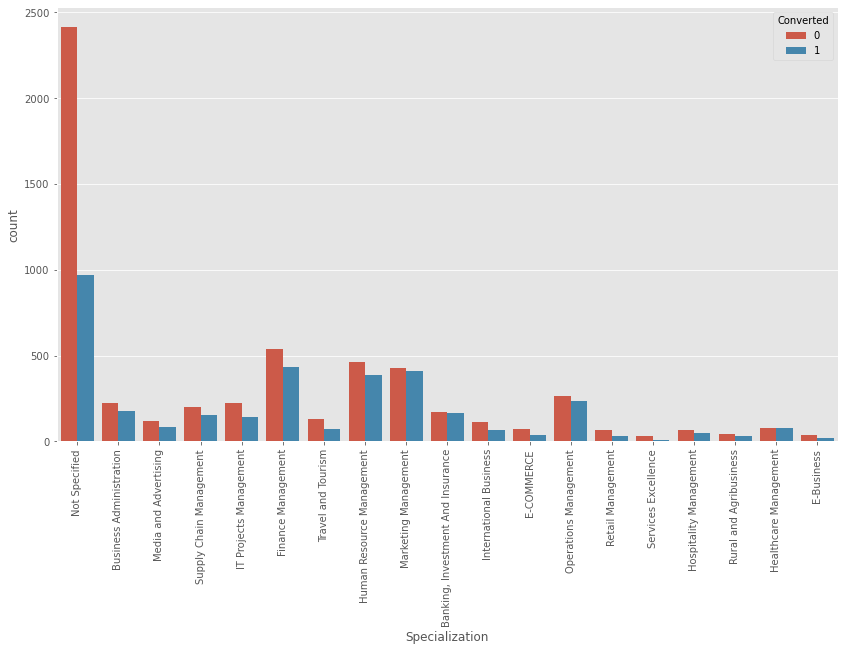

In [180]:
#plotting spread of Specialization columnn 

plt.figure(figsize=(14,8))
s1=sns.countplot(df.Specialization, hue=df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

Other than Non-Specified, if we see that specialization with ***Management*** in them have higher number of leads as well as leads converted. So this is definitely a significant variable and should not be dropped.

In [181]:
#combining Management Specializations because they show similar trends

df['Specialization'] = df['Specialization'].replace(['Finance Management','Human Resource Management',
                                                           'Marketing Management','Operations Management',
                                                           'IT Projects Management','Supply Chain Management',
                                                    'Healthcare Management','Hospitality Management',
                                                           'Retail Management'] ,'Management_Specializations') 

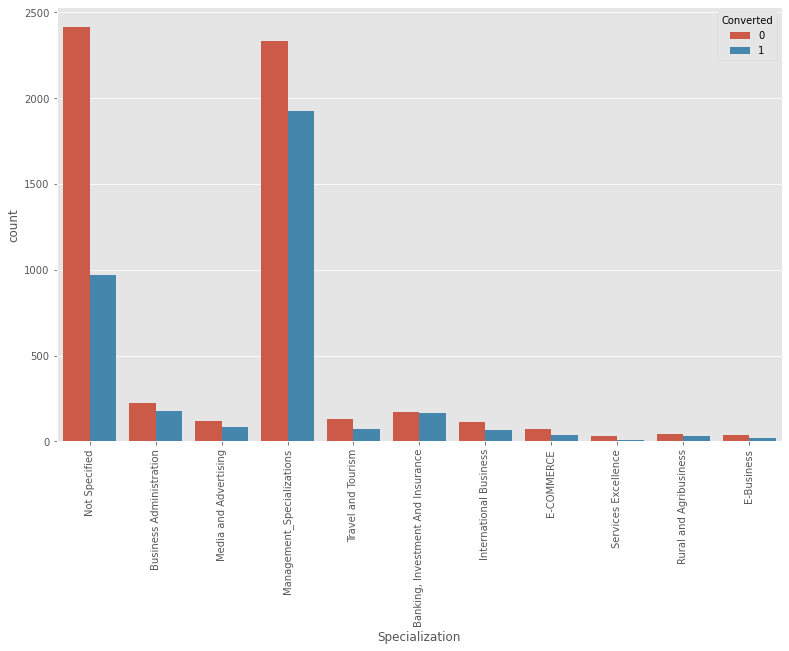

In [182]:
#visualizing count of Variable based on Converted value


plt.figure(figsize=(13,8))
s1=sns.countplot(df.Specialization, hue=df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [183]:
#What is your current occupation

df['What is your current occupation'].value_counts(dropna=False)


Unemployed              5600
NaN                     2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [184]:
#imputing Nan values with mode "Unemployed"

df['What is your current occupation'] = df['What is your current occupation'].replace(np.nan, 'Unemployed')

In [185]:
#checking count of values
df['What is your current occupation'].value_counts(dropna=False)

Unemployed              8290
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

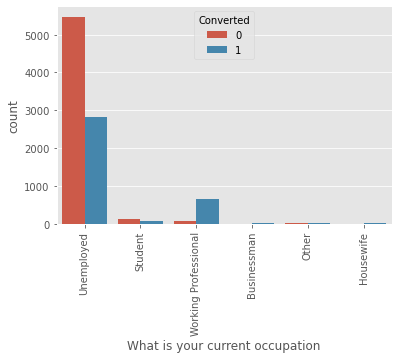

In [186]:
#visualizing count of Variable based on Converted value

s1=sns.countplot(df['What is your current occupation'], hue=df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

- Working Professionals conversion ratio is very high as compared to others. Hence, it is good to target these
- Number of leads in the unemolyed category are more in numbers.


In [187]:
#checking value counts

df['What matters most to you in choosing a course'].value_counts(dropna=False)

Better Career Prospects      6528
NaN                          2709
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

In [188]:
#replacing Nan values with Mode "Better Career Prospects"
df['What matters most to you in choosing a course'] = df['What matters most to you in choosing a course'].replace(np.nan,'Better Career Prospects')

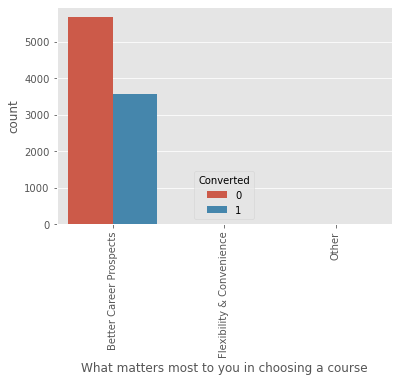

In [189]:
#visualizing count of Variable based on Converted value

s1=sns.countplot(df['What matters most to you in choosing a course'], hue=df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

- Most of the people choses the courses to have better career prospects.

In [190]:
#Here again we have another Column that is worth Dropping. So we Append to the cols_to_drop List
cols_to_drop.append('What matters most to you in choosing a course')
cols_to_drop

['Country', 'What matters most to you in choosing a course']

In [191]:
#checking value counts of Tag variable
df['Tags'].value_counts(dropna=False)

NaN                                                  3353
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch with 

In [192]:
#replacing Nan values with "Not Specified"
df['Tags'] = df['Tags'].replace(np.nan,'Not Specified')

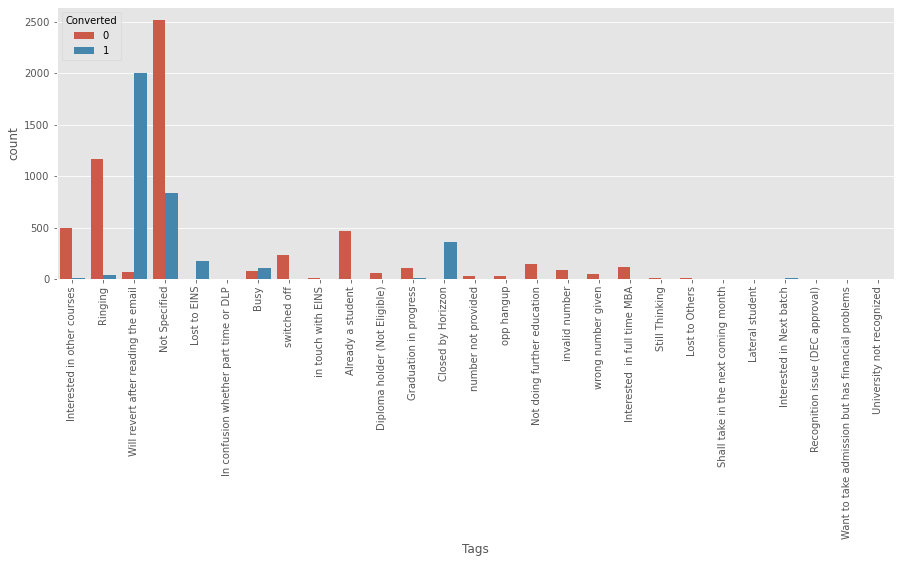

In [193]:
#visualizing count of Variable based on Converted value
plt.figure(figsize=(15,5))

s1=sns.countplot(df['Tags'], hue=df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

- The conversion ratio among the above categories is verhy high for Tag 'Will revert after reading the email'.

In [194]:
#replacing tags with low frequency with "Other Tags"
df['Tags'] = df['Tags'].replace(['In confusion whether part time or DLP', 'in touch with EINS','Diploma holder (Not Eligible)',
                                     'Approached upfront','Graduation in progress','number not provided', 'opp hangup','Still Thinking',
                                    'Lost to Others','Shall take in the next coming month','Lateral student','Interested in Next batch',
                                    'Recognition issue (DEC approval)','Want to take admission but has financial problems',
                                    'University not recognized'], 'Other_Tags')

df['Tags'] = df['Tags'].replace(['switched off',
                                      'Already a student',
                                       'Not doing further education',
                                       'invalid number',
                                       'wrong number given',
                                       'Interested  in full time MBA'] , 'Other_Tags')

In [195]:
df.head()


,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,India,Not Specified,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,No,No,Mumbai,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Not Specified,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,Mumbai,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Mumbai,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,Mumbai,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Not Specified,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Mumbai,No,No,Modified


In [196]:
#checking percentage of missing values
round(100*(df.isnull().sum()/len(df.index)), 2)

Lead Origin                                      0.00
Lead Source                                      0.39
Do Not Email                                     0.00
Do Not Call                                      0.00
Converted                                        0.00
TotalVisits                                      1.48
Total Time Spent on Website                      0.00
Page Views Per Visit                             1.48
Last Activity                                    1.11
Country                                          0.00
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Magazine                                         0.00
Newspaper Article                                0.00
X Education Forums                               0.00
Newspaper                                        0.00
Digital Advertisement       

In [197]:
#checking value counts of Lead Source column

df['Lead Source'].value_counts(dropna=False)

Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: Lead Source, dtype: int64

In [198]:
#replacing Nan Values and combining low frequency values with others
df['Lead Source'] = df['Lead Source'].replace(np.nan,'Others')
df['Lead Source'] = df['Lead Source'].replace('google','Google')
df['Lead Source'] = df['Lead Source'].replace('Facebook','Social Media')
df['Lead Source'] = df['Lead Source'].replace(['bing','Click2call','Press_Release',
                                                     'youtubechannel','welearnblog_Home',
                                                     'WeLearn','blog','Pay per Click Ads',
                                                    'testone','NC_EDM'] ,'Others')    

In [199]:
#checking again value counts of Lead Source column

df['Lead Source'].value_counts(dropna=False)

Google              2873
Direct Traffic      2543
Olark Chat          1755
Organic Search      1154
Reference            534
Welingak Website     142
Referral Sites       125
Social Media          57
Others                55
Live Chat              2
Name: Lead Source, dtype: int64

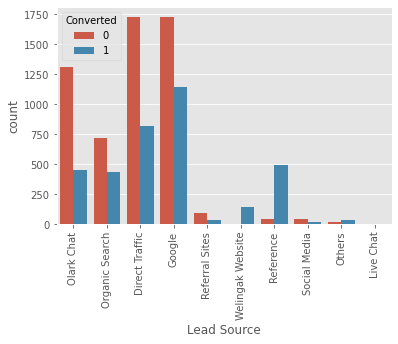

In [200]:
#visualizing count of Variable based on Converted value

s1=sns.countplot(df['Lead Source'], hue=df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

- Maximum number of leads conversion is through google.
- Direct Trafic, Organic Search, Olark Chat are some of the categories that are highly potent for conversion.
- Conversion rate of Reference, Welingak website and others have high conversion ratio.


In [201]:
# Checking the Last Activity column:

df['Last Activity'].value_counts(dropna=False)

Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
NaN                              103
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: Last Activity, dtype: int64

In [202]:
#replacing Nan Values and combining low frequency values

df['Last Activity'] = df['Last Activity'].replace(np.nan,'Others')
df['Last Activity'] = df['Last Activity'].replace(['Unreachable','Unsubscribed',
                                                        'Had a Phone Conversation', 
                                                        'Approached upfront',
                                                        'View in browser link Clicked',       
                                                        'Email Marked Spam',                  
                                                        'Email Received','Resubscribed to emails',
                                                         'Visited Booth in Tradeshow'],'Others')

In [203]:
# Checking again the Last Activity column:

df['Last Activity'].value_counts(dropna=False)

Email Opened                 3437
SMS Sent                     2745
Olark Chat Conversation       973
Page Visited on Website       640
Converted to Lead             428
Email Bounced                 326
Others                        308
Email Link Clicked            267
Form Submitted on Website     116
Name: Last Activity, dtype: int64

In [204]:
#Check the Null Values in All Columns:
round(100*(df.isnull().sum()/len(df.index)), 2)

Lead Origin                                      0.00
Lead Source                                      0.00
Do Not Email                                     0.00
Do Not Call                                      0.00
Converted                                        0.00
TotalVisits                                      1.48
Total Time Spent on Website                      0.00
Page Views Per Visit                             1.48
Last Activity                                    0.00
Country                                          0.00
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Magazine                                         0.00
Newspaper Article                                0.00
X Education Forums                               0.00
Newspaper                                        0.00
Digital Advertisement       

In [205]:
#Drop all rows which have Nan Values. Since the number of Dropped rows is less than 2%, it will not affect the model
df = df.dropna()

In [206]:
#Checking percentage of Null Values in All Columns:
round(100*(df.isnull().sum()/len(df.index)), 2)

Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                                0.0
X Education Forums                               0.0
Newspaper                                        0.0
Digital Advertisement                         

In [207]:
#Lead Origin
df['Lead Origin'].value_counts(dropna=False)

Landing Page Submission    4886
API                        3578
Lead Add Form               608
Lead Import                  31
Name: Lead Origin, dtype: int64

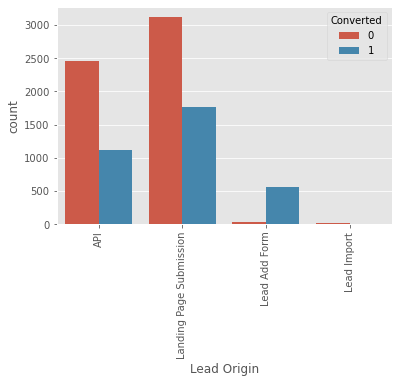

In [208]:
#visualizing count of Variable based on Converted value


s1=sns.countplot(df['Lead Origin'], hue=df.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

- Lead Add form has the highest conversion but have limited leads.
- API and Landing Page submission brings higher number of leads so focus should be on these to improve the numbers.

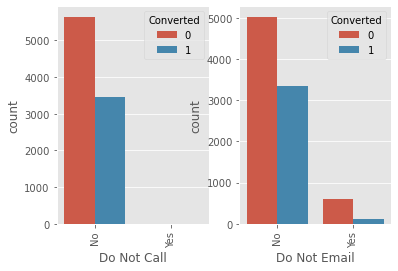

In [209]:
#Do Not Email & Do Not Call
#visualizing count of Variable based on Converted value

ax1=plt.subplot(1, 2, 1)
ax1=sns.countplot(df['Do Not Call'], hue=df.Converted)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)

ax2=plt.subplot(1, 2, 2)
ax2=sns.countplot(df['Do Not Email'], hue=df.Converted)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
plt.show()

In [210]:
#checking value counts for Do Not Call
df['Do Not Call'].value_counts(dropna=False)

No     9101
Yes       2
Name: Do Not Call, dtype: int64

We Can append the Do Not Call Column to the list of Columns to be Dropped since > 98% is of only one Value

In [211]:
cols_to_drop.append('Do Not Call')
cols_to_drop

['Country', 'What matters most to you in choosing a course', 'Do Not Call']

In [212]:
df.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Update me on Supply Chain Content,Get updates on DM Content,City,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,India,Not Specified,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,No,No,Mumbai,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Not Specified,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,Mumbai,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Mumbai,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Others,India,Media and Advertising,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,No,No,Mumbai,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Not Specified,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,No,No,Mumbai,No,No,Modified


In [213]:
#checking value counts for Do Not Email
df['Do Not Email'].value_counts(dropna=False)

No     8379
Yes     724
Name: Do Not Email, dtype: int64

In [214]:
#checking value counts of last Notable Activity
df['Last Notable Activity'].value_counts(dropna=False)

Modified                        3270
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Approached upfront                 1
Resubscribed to emails             1
View in browser link Clicked       1
Form Submitted on Website          1
Email Received                     1
Name: Last Notable Activity, dtype: int64

In [215]:
#clubbing lower frequency values

df['Last Notable Activity'] = df['Last Notable Activity'].replace(['Had a Phone Conversation',
                                                                       'Email Marked Spam',
                                                                         'Unreachable',
                                                                         'Unsubscribed',
                                                                         'Email Bounced',                                                                    
                                                                       'Resubscribed to emails',
                                                                       'View in browser link Clicked',
                                                                       'Approached upfront', 
                                                                       'Form Submitted on Website', 
                                                                       'Email Received'],'Other_Notable_activity')

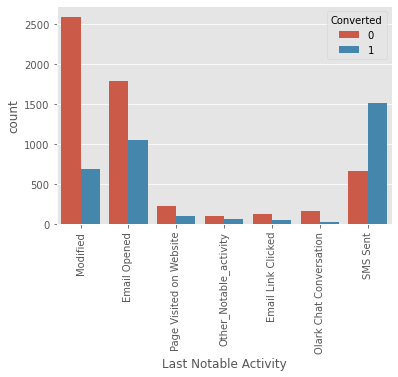

In [216]:
#visualizing count of Variable based on Converted value

ax1=sns.countplot(x = "Last Notable Activity", hue = "Converted", data = df )
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
plt.show()

#### IMBALANCED VARIABLES THAT CAN BE DROPPED

In [217]:
df.Search.value_counts(dropna=False)

No     9089
Yes      14
Name: Search, dtype: int64

In [218]:
df['Newspaper Article'].value_counts(dropna=False)

No     9101
Yes       2
Name: Newspaper Article, dtype: int64

In [219]:
df.Magazine.value_counts(dropna=False)

No    9103
Name: Magazine, dtype: int64

In [220]:
df['Newspaper'].value_counts(dropna=False)

No     9102
Yes       1
Name: Newspaper, dtype: int64

In [221]:
df['X Education Forums'].value_counts(dropna=False)

No     9102
Yes       1
Name: X Education Forums, dtype: int64

In [222]:
df['Receive More Updates About Our Courses'].value_counts(dropna=False)

No    9103
Name: Receive More Updates About Our Courses, dtype: int64

In [223]:
df['Through Recommendations'].value_counts(dropna=False)

No     9096
Yes       7
Name: Through Recommendations, dtype: int64

In [224]:
df['Digital Advertisement'].value_counts(dropna=False)

No     9099
Yes       4
Name: Digital Advertisement, dtype: int64

In [225]:
df['I agree to pay the amount through cheque'].value_counts(dropna=False)

No    9103
Name: I agree to pay the amount through cheque, dtype: int64

In [226]:
df['Get updates on DM Content'].value_counts(dropna=False)

No    9103
Name: Get updates on DM Content, dtype: int64

In [227]:
df['Update me on Supply Chain Content'].value_counts(dropna=False)

No    9103
Name: Update me on Supply Chain Content, dtype: int64

In [228]:
df['A free copy of Mastering The Interview'].value_counts(dropna=False)

No     6215
Yes    2888
Name: A free copy of Mastering The Interview, dtype: int64

In [229]:
#adding imbalanced columns to the list of columns to be dropped

cols_to_drop.extend(['Search','Magazine','Newspaper Article','X Education Forums','Newspaper',
                 'Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses',
                 'Update me on Supply Chain Content',
                 'Get updates on DM Content','I agree to pay the amount through cheque'])

In [230]:
#checking value counts of last Notable Activity
df['Last Notable Activity'].value_counts()

Modified                   3270
Email Opened               2827
SMS Sent                   2172
Page Visited on Website     318
Olark Chat Conversation     183
Email Link Clicked          173
Other_Notable_activity      160
Name: Last Notable Activity, dtype: int64

In [231]:
#clubbing lower frequency values

df['Last Notable Activity'] = df['Last Notable Activity'].replace(['Had a Phone Conversation',
                                                                       'Email Marked Spam',
                                                                         'Unreachable',
                                                                         'Unsubscribed',
                                                                         'Email Bounced',                                                                    
                                                                       'Resubscribed to emails',
                                                                       'View in browser link Clicked',
                                                                       'Approached upfront', 
                                                                       'Form Submitted on Website', 
                                                                       'Email Received'],'Other_Notable_activity')

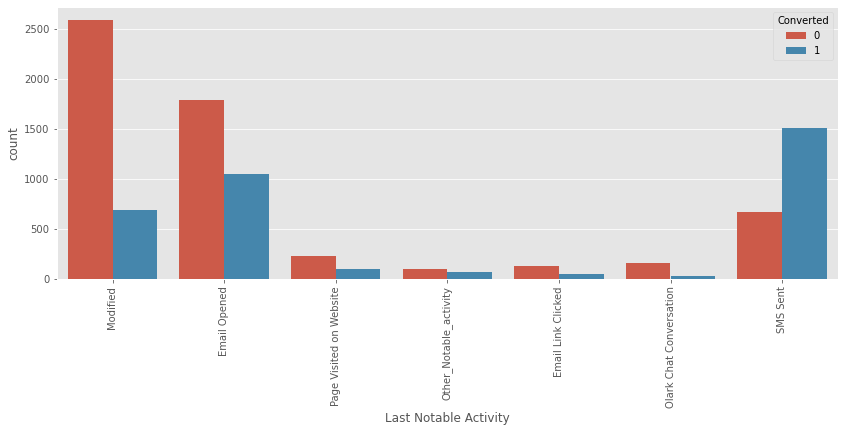

In [232]:
#visualizing count of Variable based on Converted value

plt.figure(figsize = (14,5))
ax1=sns.countplot(x = "Last Notable Activity", hue = "Converted", data = df)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
plt.show()

In [233]:
#list of columns to be dropped
cols_to_drop

['Country',
 'What matters most to you in choosing a course',
 'Do Not Call',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'I agree to pay the amount through cheque']

In [234]:
#dropping columns
df = df.drop(cols_to_drop,1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9103 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9103 non-null   object 
 1   Lead Source                             9103 non-null   object 
 2   Do Not Email                            9103 non-null   object 
 3   Converted                               9103 non-null   int64  
 4   TotalVisits                             9103 non-null   float64
 5   Total Time Spent on Website             9103 non-null   int64  
 6   Page Views Per Visit                    9103 non-null   float64
 7   Last Activity                           9103 non-null   object 
 8   Specialization                          9103 non-null   object 
 9   What is your current occupation         9103 non-null   object 
 10  Tags                                    9103 non-null   obje

### Analysis of Continous Variable

In [235]:
#Check the % of Data that has Converted Values = 1:

Converted = (sum(df['Converted'])/len(df['Converted'].index))*100
Converted

38.02043282434362

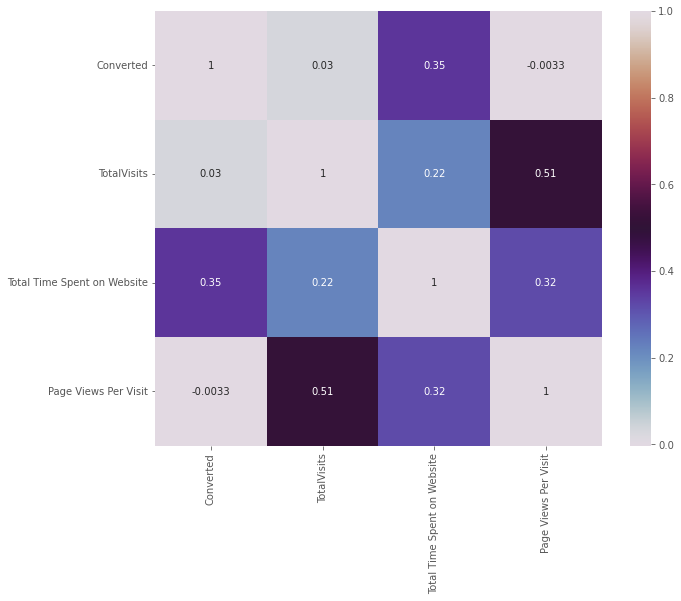

In [236]:
#Checking correlations of numeric values
# figure size
plt.figure(figsize=(10,8))

# heatmap
sns.heatmap(df.corr(), cmap="twilight", annot=True)
plt.show()

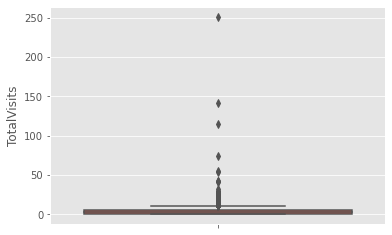

In [237]:
#Total Visits
#visualizing spread of variable

plt.figure(figsize=(6,4))
sns.boxplot(y=df['TotalVisits'])
plt.show()

- We can clearly see the outliers there.

In [238]:
#checking percentile values for "Total Visits"

df['TotalVisits'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
5%          0.000000
25%         1.000000
50%         3.000000
75%         5.000000
90%         7.000000
95%        10.000000
99%        17.000000
max       251.000000
Name: TotalVisits, dtype: float64

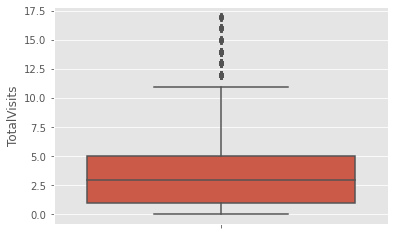

In [239]:
#Outlier Treatment: Remove top & bottom 1% of the Column Outlier values

Q3 = df.TotalVisits.quantile(0.99)
df = df[(df.TotalVisits <= Q3)]
Q1 = df.TotalVisits.quantile(0.01)
df = df[(df.TotalVisits >= Q1)]
sns.boxplot(y=df['TotalVisits'])
plt.show()

In [240]:
df.shape

(9020, 14)

In [241]:
#checking percentiles for "Total Time Spent on Website"

df['Total Time Spent on Website'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    9020.000000
mean      479.759534
std       544.688157
min         0.000000
5%          0.000000
25%         7.000000
50%       243.000000
75%       915.250000
90%      1371.000000
95%      1554.050000
99%      1836.620000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

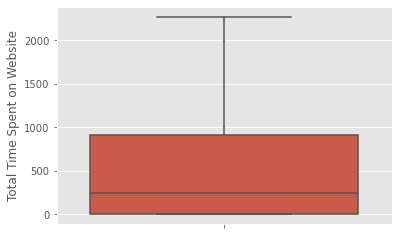

In [242]:
#visualizing spread of numeric variable

plt.figure(figsize=(6,4))
sns.boxplot(y=df['Total Time Spent on Website'])
plt.show()

- As we can see there is no oulier, thus No treatment Required.

In [243]:
#checking spread of "Page Views Per Visit"

df['Page Views Per Visit'].describe()

count    9020.000000
mean        2.337271
std         2.062363
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        16.000000
Name: Page Views Per Visit, dtype: float64

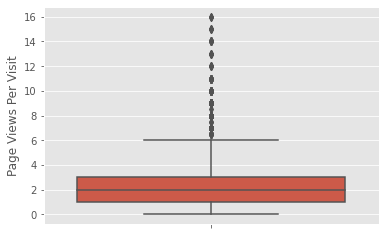

In [244]:
#visualizing spread of numeric variable

plt.figure(figsize=(6,4))
sns.boxplot(y=df['Page Views Per Visit'])
plt.show()

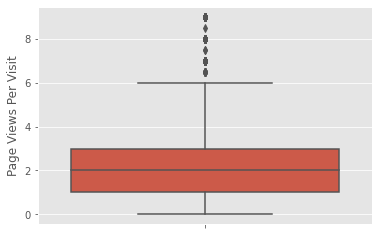

In [245]:
#Outlier Treatment: Remove top & bottom 1% 

Q3 = df['Page Views Per Visit'].quantile(0.99)
df = df[df['Page Views Per Visit'] <= Q3]
Q1 = df['Page Views Per Visit'].quantile(0.01)
df = df[df['Page Views Per Visit'] >= Q1]
sns.boxplot(y=df['Page Views Per Visit'])
plt.show()

In [246]:
df.shape

(8953, 14)

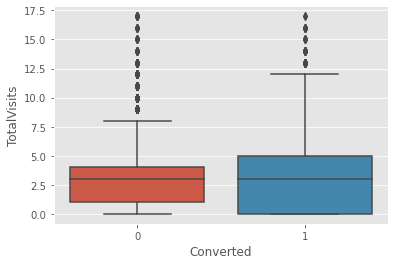

In [247]:
#checking Spread of "Total Visits" vs Converted variable
sns.boxplot(y = 'TotalVisits', x = 'Converted', data = df)
plt.show()

- As median are almost at the same level , nothing conclusive can be drawn.

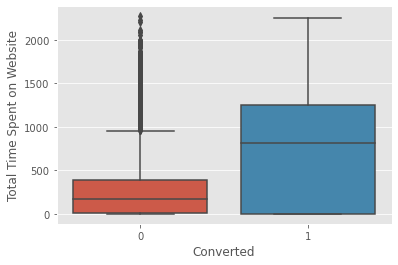

In [248]:
#checking Spread of "Total Time Spent on Website" vs Converted variable

sns.boxplot(x=df.Converted, y=df['Total Time Spent on Website'])
plt.show()

`Inference`

- Leads spending more time on the website are more likely to be converted.

- Website should be made more engaging to make leads spend more time.

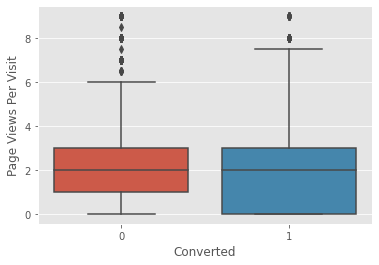

In [249]:
#checking Spread of "Page Views Per Visit" vs Converted variable

sns.boxplot(x=df.Converted,y=df['Page Views Per Visit'])
plt.show()

`Inference`

- Median for converted and unconverted leads is the same.
- Nothing can be said specifically for lead conversion from Page Views Per Visit

In [250]:
#checking missing values in leftover columns/

round(100*(df.isnull().sum()/len(df.index)),2)

Lead Origin                               0.0
Lead Source                               0.0
Do Not Email                              0.0
Converted                                 0.0
TotalVisits                               0.0
Total Time Spent on Website               0.0
Page Views Per Visit                      0.0
Last Activity                             0.0
Specialization                            0.0
What is your current occupation           0.0
Tags                                      0.0
City                                      0.0
A free copy of Mastering The Interview    0.0
Last Notable Activity                     0.0
dtype: float64

- No missing values


In [251]:
df.head()

,Lead Origin,Lead Source,Do Not Email,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Specialization,What is your current occupation,Tags,City,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,0,0.0,0,0.0,Page Visited on Website,Not Specified,Unemployed,Interested in other courses,Mumbai,No,Modified
1,API,Organic Search,No,0,5.0,674,2.5,Email Opened,Not Specified,Unemployed,Ringing,Mumbai,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,1,2.0,1532,2.0,Email Opened,Business Administration,Student,Will revert after reading the email,Mumbai,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,0,1.0,305,1.0,Others,Media and Advertising,Unemployed,Ringing,Mumbai,No,Modified
4,Landing Page Submission,Google,No,1,2.0,1428,1.0,Converted to Lead,Not Specified,Unemployed,Will revert after reading the email,Mumbai,No,Modified


## Creating Dummy Variable

In [252]:
#getting a list of categorical columns

cat_cols= df.select_dtypes(include=['object']).columns
cat_cols

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity',
       'Specialization', 'What is your current occupation', 'Tags', 'City',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [253]:
# List of variables to map

varlist =  ['A free copy of Mastering The Interview','Do Not Email']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
df[varlist] = df[varlist].apply(binary_map)

In [254]:
#getting dummies and dropping the first column and adding the results to the master dataframe
dummy = pd.get_dummies(df[['Lead Origin','What is your current occupation',
                             'City']], drop_first=True)
df = pd.concat([df,dummy],1)

In [255]:
dummy = pd.get_dummies(df['Specialization'], prefix  = 'Specialization')
dummy = dummy.drop(['Specialization_Not Specified'], 1)
df = pd.concat([df, dummy], axis = 1)

In [256]:
dummy = pd.get_dummies(df['Lead Source'], prefix  = 'Lead Source')
dummy = dummy.drop(['Lead Source_Others'], 1)
df = pd.concat([df, dummy], axis = 1)

In [257]:
dummy = pd.get_dummies(df['Last Activity'], prefix  = 'Last Activity')
dummy = dummy.drop(['Last Activity_Others'], 1)
df = pd.concat([df, dummy], axis = 1)

In [258]:
dummy = pd.get_dummies(df['Last Notable Activity'], prefix  = 'Last Notable Activity')
dummy = dummy.drop(['Last Notable Activity_Other_Notable_activity'], 1)
df = pd.concat([df, dummy], axis = 1)

In [259]:
dummy = pd.get_dummies(df['Tags'], prefix  = 'Tags')
dummy = dummy.drop(['Tags_Not Specified'], 1)
df = pd.concat([df, dummy], axis = 1)

In [260]:
#dropping the original columns after dummy variable creation

df.drop(cat_cols,1,inplace = True)

In [261]:
df.head()

,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_International Business,Specialization_Management_Specializations,Specialization_Media and Advertising,Specialization_Rural and Agribusiness,...,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Tags_Busy,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email
0,0,0.0,0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1,0,5.0,674,2.5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2,1,2.0,1532,2.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,0,1.0,305,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,1,2.0,1428,1.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [262]:
df.shape

(8953, 57)

### Modelling

- Train-Test Split & Logistic Regression Model Building:

In [263]:
from sklearn.model_selection import train_test_split

# Putting response variable to y
y = df['Converted']

y.head()

X=df.drop('Converted', axis=1)

In [264]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [265]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6267 entries, 9196 to 5825
Data columns (total 56 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   TotalVisits                                           6267 non-null   float64
 1   Total Time Spent on Website                           6267 non-null   int64  
 2   Page Views Per Visit                                  6267 non-null   float64
 3   Lead Origin_Landing Page Submission                   6267 non-null   uint8  
 4   Lead Origin_Lead Add Form                             6267 non-null   uint8  
 5   Lead Origin_Lead Import                               6267 non-null   uint8  
 6   What is your current occupation_Housewife             6267 non-null   uint8  
 7   What is your current occupation_Other                 6267 non-null   uint8  
 8   What is your current occupation_Student               6

### Scaling of Data

In [268]:
# Scaling Numerical columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols=X_train.select_dtypes(include=['float64', 'int64']).columns

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

X_train.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_International Business,Specialization_Management_Specializations,Specialization_Media and Advertising,Specialization_Rural and Agribusiness,Specialization_Services Excellence,...,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Tags_Busy,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email
9196,0.668862,1.848117,1.455819,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4696,-0.030697,-0.037832,0.399961,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
3274,0.319082,-0.642138,-0.127967,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2164,-0.380477,-0.154676,-0.127967,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1667,0.319082,1.258415,-0.481679,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


### Model Building using Stats Model & RFE:

In [269]:
import statsmodels.api as sm

In [270]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.feature_selection import RFE
rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [271]:
rfe.support_

array([False,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True])

In [272]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', False, 26),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 24),
 ('Lead Origin_Landing Page Submission', False, 10),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 16),
 ('What is your current occupation_Housewife', False, 31),
 ('What is your current occupation_Other', False, 34),
 ('What is your current occupation_Student', False, 23),
 ('What is your current occupation_Unemployed', False, 20),
 ('What is your current occupation_Working Professional', False, 8),
 ('City_Other Cities', False, 22),
 ('City_Other Cities of Maharashtra', False, 37),
 ('City_Other Metro Cities', False, 40),
 ('City_Thane & Outskirts', False, 38),
 ('City_Tier II Cities', False, 28),
 ('Specialization_Banking, Investment And Insurance', False, 14),
 ('Specialization_Business Administration', False, 39),
 ('Specialization_E-Business', False, 35),
 ('Specialization_E-COMMERCE', False, 21),
 ('Specialization_International Business', F

In [273]:
#list of RFE supported columns
col = X_train.columns[rfe.support_]
col

Index(['Total Time Spent on Website', 'Lead Origin_Lead Add Form',
       'Lead Source_Direct Traffic', 'Lead Source_Referral Sites',
       'Lead Source_Welingak Website', 'Last Activity_SMS Sent',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation',
       'Last Notable Activity_SMS Sent', 'Tags_Closed by Horizzon',
       'Tags_Interested in other courses', 'Tags_Lost to EINS',
       'Tags_Other_Tags', 'Tags_Ringing',
       'Tags_Will revert after reading the email'],
      dtype='object')

In [274]:
X_train.columns[~rfe.support_]

Index(['TotalVisits', 'Page Views Per Visit',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'What is your current occupation_Housewife',
       'What is your current occupation_Other',
       'What is your current occupation_Student',
       'What is your current occupation_Unemployed',
       'What is your current occupation_Working Professional',
       'City_Other Cities', 'City_Other Cities of Maharashtra',
       'City_Other Metro Cities', 'City_Thane & Outskirts',
       'City_Tier II Cities',
       'Specialization_Banking, Investment And Insurance',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_International Business',
       'Specialization_Management_Specializations',
       'Specialization_Media and Advertising',
       'Specialization_Rural and Agribusiness',
       'Specialization_Services Excellence',
       'Specialization_Travel and Tourism', 'Lead Sourc

In [275]:
#BUILDING MODEL #1

X_train_sm = sm.add_constant(X_train[col])
logm1 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6267
Model:                            GLM   Df Residuals:                     6251
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1254.7
Date:                Mon, 11 Jul 2022   Deviance:                       2509.3
Time:                        19:04:34   Pearson chi2:                 8.34e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -1.1899      0.088    -13.480      0.000      -1.363      -1.017
Total Time Spent on Website                       0.8970      0.053     16.999      0.000       0.794       1.000
Lead Origin_Lead Add Form                         1.6712      0.450      3.714      0.000       0.789       2.553
Lead Source_Direct Traffic                       -0.8320      0.129     -6.471      0.000      -1.084      -0.580
Lead Source_Referral Sites                       -0.5284      0.465     -1.138      0.255      -1.439       0.382
Lead Source_Welingak Website                      3.9043      1.110      3.518      0.000       1.729       6.079
Last Activity_SMS Sent                            1.2373      0.223      5.555      0.000       0.801       1.674
Last Notable Activity_Modified                   -1.2839      0.150     -8.532      0.000      -1.579      -0.989
Last Notable Activity_Olark Chat Conversation    -1.7123      0.490     -3.496      0.000      -2.672      -0.752
Last Notable Activity_SMS Sent                    1.0151      0.257      3.943      0.000       0.511       1.520
Tags_Closed by Horizzon                           6.9834      1.019      6.853      0.000       4.986       8.981
Tags_Interested in other courses                 -2.1641      0.407     -5.321      0.000      -2.961      -1.367
Tags_Lost to EINS                                 5.7302      0.608      9.419      0.000       4.538       6.923
Tags_Other_Tags                                  -2.4417      0.210    -11.633      0.000      -2.853      -2.030
Tags_Ringing                                     -3.5858      0.243    -14.752      0.000      -4.062      -3.109
Tags_Will revert after reading the email          4.4263      0.185     23.989      0.000       4.065       4.788
=================================================================================================================
"""

p-value of variable Lead Source_Referral Sites is high, so we can drop it.

In [276]:
#dropping column with high p-value

col = col.drop('Lead Source_Referral Sites',1)

## Building Model #2

In [277]:
#BUILDING MODEL #2

X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6267
Model:                            GLM   Df Residuals:                     6252
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1255.3
Date:                Mon, 11 Jul 2022   Deviance:                       2510.7
Time:                        19:05:26   Pearson chi2:                 8.34e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -1.2029      0.088    -13.729      0.000      -1.375      -1.031
Total Time Spent on Website                       0.8963      0.053     16.979      0.000       0.793       1.000
Lead Origin_Lead Add Form                         1.6795      0.450      3.735      0.000       0.798       2.561
Lead Source_Direct Traffic                       -0.8224      0.128     -6.409      0.000      -1.074      -0.571
Lead Source_Welingak Website                      3.9060      1.110      3.520      0.000       1.731       6.081
Last Activity_SMS Sent                            1.2437      0.223      5.584      0.000       0.807       1.680
Last Notable Activity_Modified                   -1.2791      0.150     -8.501      0.000      -1.574      -0.984
Last Notable Activity_Olark Chat Conversation    -1.7079      0.489     -3.491      0.000      -2.667      -0.749
Last Notable Activity_SMS Sent                    1.0150      0.257      3.943      0.000       0.510       1.520
Tags_Closed by Horizzon                           6.9868      1.019      6.857      0.000       4.990       8.984
Tags_Interested in other courses                 -2.2028      0.409     -5.391      0.000      -3.004      -1.402
Tags_Lost to EINS                                 5.7337      0.608      9.426      0.000       4.541       6.926
Tags_Other_Tags                                  -2.4401      0.210    -11.625      0.000      -2.852      -2.029
Tags_Ringing                                     -3.5818      0.243    -14.740      0.000      -4.058      -3.106
Tags_Will revert after reading the email          4.4234      0.184     23.993      0.000       4.062       4.785
=================================================================================================================
"""

Since 'All' the p-values are less we can check the Variance Inflation Factor to see if there is any correlation between the variables


In [278]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [279]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
7,Last Notable Activity_SMS Sent,6.22
4,Last Activity_SMS Sent,6.12
1,Lead Origin_Lead Add Form,1.82
5,Last Notable Activity_Modified,1.69
13,Tags_Will revert after reading the email,1.61
2,Lead Source_Direct Traffic,1.38
3,Lead Source_Welingak Website,1.34
11,Tags_Other_Tags,1.26
0,Total Time Spent on Website,1.22
8,Tags_Closed by Horizzon,1.21


In [280]:
#dropping variable with high VIF

col = col.drop('Last Notable Activity_SMS Sent',1)

In [281]:
#BUILDING MODEL #3
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6267
Model:                            GLM   Df Residuals:                     6253
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1263.3
Date:                Mon, 11 Jul 2022   Deviance:                       2526.6
Time:                        19:06:34   Pearson chi2:                 8.51e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -1.1179      0.084    -13.382      0.000      -1.282      -0.954
Total Time Spent on Website                       0.8896      0.053     16.907      0.000       0.786       0.993
Lead Origin_Lead Add Form                         1.6630      0.455      3.657      0.000       0.772       2.554
Lead Source_Direct Traffic                       -0.8212      0.127     -6.471      0.000      -1.070      -0.572
Lead Source_Welingak Website                      3.8845      1.114      3.488      0.000       1.701       6.068
Last Activity_SMS Sent                            1.9981      0.113     17.718      0.000       1.777       2.219
Last Notable Activity_Modified                   -1.6525      0.124    -13.279      0.000      -1.896      -1.409
Last Notable Activity_Olark Chat Conversation    -1.8023      0.491     -3.669      0.000      -2.765      -0.839
Tags_Closed by Horizzon                           7.1955      1.020      7.053      0.000       5.196       9.195
Tags_Interested in other courses                 -2.1318      0.406     -5.253      0.000      -2.927      -1.336
Tags_Lost to EINS                                 5.9177      0.611      9.689      0.000       4.721       7.115
Tags_Other_Tags                                  -2.3737      0.206    -11.507      0.000      -2.778      -1.969
Tags_Ringing                                     -3.4531      0.238    -14.532      0.000      -3.919      -2.987
Tags_Will revert after reading the email          4.5070      0.188     24.002      0.000       4.139       4.875
=================================================================================================================
"""

In [282]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,Lead Origin_Lead Add Form,1.82
12,Tags_Will revert after reading the email,1.56
4,Last Activity_SMS Sent,1.46
5,Last Notable Activity_Modified,1.40
2,Lead Source_Direct Traffic,1.38
3,Lead Source_Welingak Website,1.34
10,Tags_Other_Tags,1.25
0,Total Time Spent on Website,1.22
7,Tags_Closed by Horizzon,1.21
11,Tags_Ringing,1.16


So the Values all seem to be in order so now, Moving on to derive the Probabilities, Lead Score, Predictions on Train Data:


In [283]:
# Getting the Predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

9196    0.283149
4696    0.031440
3274    0.576636
2164    0.006433
1667    0.989105
7024    0.130813
8018    0.024219
778     0.205594
6942    0.002678
4440    0.096716
dtype: float64

In [284]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.28314859, 0.0314396 , 0.57663553, 0.00643284, 0.98910464,
       0.13081306, 0.02421913, 0.20559401, 0.00267787, 0.09671623])

In [285]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred})
y_train_pred_final['Prospect ID'] = y_train.index
y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID
0,1,0.283149,9196
1,0,0.031440,4696
2,0,0.576636,3274
3,0,0.006433,2164
4,1,0.989105,1667


In [286]:
y_train_pred_final['Predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID,Predicted
0,1,0.283149,9196,0
1,0,0.031440,4696,0
2,0,0.576636,3274,1
3,0,0.006433,2164,0
4,1,0.989105,1667,1


In [287]:
from sklearn import metrics

# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.Predicted )
print(confusion)

[[3693  189]
 [ 281 2104]]


In [288]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.Predicted))

0.9250039891495133


In [289]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [290]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8821802935010482

In [291]:
# Let us calculate specificity
TN / float(TN+FP)

0.9513137557959814

In [292]:
# Calculate False Postive Rate - predicting conversion when customer does not have convert
print(FP/ float(TN+FP))

0.04868624420401855


In [293]:
# positive predictive value 
print (TP / float(TP+FP))

0.9175752289576974


In [294]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9292903875188727


### Plotting ROC Curve

In [296]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [297]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_prob, drop_intermediate = False )


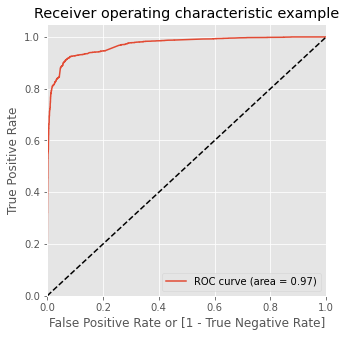

In [298]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

##### The ROC Curve should be a value close to 1. We are getting a good value of 0.97 indicating a good predictive model.


### Finding Optimal Cutoff Point

Above we had chosen an arbitrary cut-off value of 0.5. We need to determine the best cut-off value and the below section deals with that:

In [299]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1,0.283149,9196,0,1,1,1,0,0,0,0,0,0,0
1,0,0.031440,4696,0,1,0,0,0,0,0,0,0,0,0
2,0,0.576636,3274,1,1,1,1,1,1,1,0,0,0,0
3,0,0.006433,2164,0,1,0,0,0,0,0,0,0,0,0
4,1,0.989105,1667,1,1,1,1,1,1,1,1,1,1,1


In [300]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.380565  1.000000  0.000000
0.1   0.1  0.816180  0.971488  0.720762
0.2   0.2  0.901069  0.931237  0.882535
0.3   0.3  0.922930  0.916981  0.926584
0.4   0.4  0.925802  0.901468  0.940752
0.5   0.5  0.925004  0.882180  0.951314
0.6   0.6  0.915909  0.828092  0.969861
0.7   0.7  0.916228  0.810063  0.981453
0.8   0.8  0.906335  0.774843  0.987120
0.9   0.9  0.887027  0.718239  0.990726


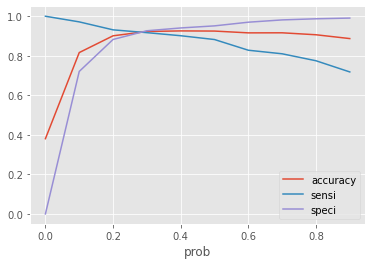

In [301]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [302]:
#### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

y_train_pred_final['final_Predicted'] = y_train_pred_final.Converted_prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Converted,Converted_prob,Prospect ID,Predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_Predicted
0,1,0.283149,9196,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0.031440,4696,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0.576636,3274,1,1,1,1,1,1,1,0,0,0,0,1
3,0,0.006433,2164,0,1,0,0,0,0,0,0,0,0,0,0
4,1,0.989105,1667,1,1,1,1,1,1,1,1,1,1,1,1


In [303]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.Converted_prob.map( lambda x: round(x*100))

y_train_pred_final[['Converted','Converted_prob','Prospect ID','final_Predicted','Lead_Score']].head()

,Converted,Converted_prob,Prospect ID,final_Predicted,Lead_Score
0,1,0.283149,9196,0,28
1,0,0.031440,4696,0,3
2,0,0.576636,3274,1,58
3,0,0.006433,2164,0,1
4,1,0.989105,1667,1,99


In [304]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)

0.922929631402585

In [305]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_Predicted )
confusion2

array([[3597,  285],
       [ 198, 2187]], dtype=int64)

In [306]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [307]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9169811320754717

In [308]:
# Let us calculate specificity
TN / float(TN+FP)

0.9265842349304482

Observation: So as we can see above the model seems to be performing well. The ROC curve has a value of 0.97, which is very good. We have the following values for the Train Data:

Accuracy : 92.29%
Sensitivity : 91.70%
Specificity : 92.66% Some of the other Stats are derived below, indicating the False Positive Rate, Positive Predictive Value,Negative Predictive Values, Precision & Recall.

In [309]:
# Calculate False Postive Rate - predicting conversion when customer does not have convert
print(FP/ float(TN+FP))

0.07341576506955177


In [310]:
# Positive predictive value 
print (TP / float(TP+FP))

0.8847087378640777


In [311]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9478260869565217


In [312]:
#Looking at the confusion matrix again

confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_Predicted )
confusion

array([[3597,  285],
       [ 198, 2187]], dtype=int64)

In [313]:
#### Precision
TP / TP + FP

confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.8847087378640777

In [314]:
##### Recall
TP / TP + FN

confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.9169811320754717

In [315]:
from sklearn.metrics import precision_score, recall_score

In [316]:
precision_score(y_train_pred_final.Converted , y_train_pred_final.final_Predicted)

0.8847087378640777

In [317]:
recall_score(y_train_pred_final.Converted, y_train_pred_final.final_Predicted)

0.9169811320754717

In [318]:
from sklearn.metrics import precision_recall_curve

In [319]:
y_train_pred_final.Converted, y_train_pred_final.final_Predicted
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

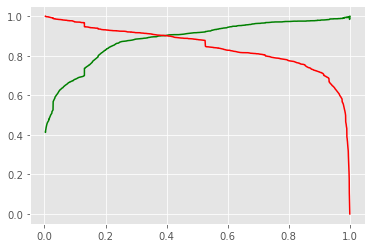

In [320]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [321]:
#scaling test set

num_cols=X_test.select_dtypes(include=['float64', 'int64']).columns

X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

X_test.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_International Business,Specialization_Management_Specializations,Specialization_Media and Advertising,Specialization_Rural and Agribusiness,Specialization_Services Excellence,...,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Social Media,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent,Tags_Busy,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email
7681,0.575687,-0.311318,0.092860,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
984,-0.090676,-0.550262,0.356568,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
8135,-0.423857,0.812462,-0.170849,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
6915,0.242505,-0.628665,-0.170849,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
2712,-0.090676,-0.421456,0.356568,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [322]:
X_test = X_test[col]
X_test.head()

,Total Time Spent on Website,Lead Origin_Lead Add Form,Lead Source_Direct Traffic,Lead Source_Welingak Website,Last Activity_SMS Sent,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Other_Tags,Tags_Ringing,Tags_Will revert after reading the email
7681,-0.311318,0,1,0,1,0,0,0,0,0,0,1,0
984,-0.550262,0,0,0,1,1,0,0,0,0,1,0,0
8135,0.812462,0,1,0,1,0,0,0,0,0,0,0,0
6915,-0.628665,0,0,0,0,0,0,0,0,0,0,1,0
2712,-0.421456,0,0,0,0,0,0,0,0,0,0,0,1


In [323]:
X_test_sm = sm.add_constant(X_test)

## PREDICTIONS ON TEST SET

In [325]:
y_test_pred = res.predict(X_test_sm)

In [326]:
y_test_pred[:10]

7681    0.024819
984     0.025692
8135    0.686054
6915    0.005880
2712    0.953208
244     0.002398
4698    0.014697
8287    0.027549
6791    0.981608
8970    0.005703
dtype: float64

In [327]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [328]:
# Let's see the head
y_pred_1.head()

,0
7681,0.024819
984,0.025692
8135,0.686054
6915,0.005880
2712,0.953208


In [329]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [330]:
# Putting CustID to index
y_test_df['Prospect ID'] = y_test_df.index

In [331]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [332]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [333]:
y_pred_final.head()

,Converted,Prospect ID,0
0,0,7681,0.024819
1,0,984,0.025692
2,0,8135,0.686054
3,0,6915,0.005880
4,1,2712,0.953208


In [334]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_prob'})

In [335]:
y_pred_final.head()

,Converted,Prospect ID,Converted_prob
0,0,7681,0.024819
1,0,984,0.025692
2,0,8135,0.686054
3,0,6915,0.005880
4,1,2712,0.953208


In [336]:
# Rearranging the columns
y_pred_final = y_pred_final[['Prospect ID','Converted','Converted_prob']]
y_pred_final['Lead_Score'] = y_pred_final.Converted_prob.map( lambda x: round(x*100))

In [337]:
# Let's see the head of y_pred_final
y_pred_final.head()

,Prospect ID,Converted,Converted_prob,Lead_Score
0,7681,0,0.024819,2
1,984,0,0.025692,3
2,8135,0,0.686054,69
3,6915,0,0.005880,1
4,2712,1,0.953208,95


In [338]:
y_pred_final['final_Predicted'] = y_pred_final.Converted_prob.map(lambda x: 1 if x > 0.3 else 0)


In [353]:
y_pred_final

,Prospect ID,Converted,Converted_prob,Lead_Score,final_Predicted
0,7681,0,0.024819,2,0
1,984,0,0.025692,3,0
2,8135,0,0.686054,69,1
3,6915,0,0.005880,1,0
4,2712,1,0.953208,95,1
...,...,...,...,...,...
2681,9029,1,0.027549,3,0
2682,1420,0,0.045029,5,0
2683,5996,1,0.965338,97,1
2684,4143,0,0.003836,0,0


In [340]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_Predicted)

0.9277736411020104

In [341]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_Predicted )
confusion2

array([[1563,  113],
       [  81,  929]], dtype=int64)

In [342]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [343]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9198019801980198

In [344]:
# Let us calculate specificity
TN / float(TN+FP)

0.9325775656324582

In [345]:
precision_score(y_pred_final.Converted , y_pred_final.final_Predicted)

0.8915547024952015

In [346]:
recall_score(y_pred_final.Converted, y_pred_final.final_Predicted)

0.9198019801980198

## Observation:
After running the model on the Test Data these are the figures we obtain:

Accuracy : 92.78%
Sensitivity : 91.98%
Specificity : 93.26%

### Final Observation:
Let us compare the values obtained for Train & Test:

Train Data:
Accuracy : 92.29%
Sensitivity : 91.70%
Specificity : 92.66%


Test Data:
Accuracy : 92.78%
Sensitivity : 91.98%
Specificity : 93.26%

The Model seems to predict the Conversion Rate very well and we should be able to give the CEO confidence in making good calls based on this model

In [347]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "kushagra-95saxena/lead-scoring-assignment" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/kushagra-95saxena/lead-scoring-assignment


'https://jovian.ai/kushagra-95saxena/lead-scoring-assignment'